In [2]:
import base64
import requests

# OpenAI API Key
with open("openai-key.txt", "r") as f:
    api_key = f.readline()

headers = {
  "Content-Type": "application/json",
  "Authorization": f"Bearer {api_key}"
}

In [17]:
def generate(prompt, image_path, verbose = False):
    with open(image_path, "rb") as image_file:
        base64_image = base64.b64encode(image_file.read()).decode('utf-8')
    payload = {
      "model": "gpt-4-vision-preview",
      "messages": [
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": prompt
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image}",
                  "detail": "low"
              }
            }
          ]
        }
      ],
      "max_tokens": 128
    }
    
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload).json()
    if verbose:
        from PIL import Image
        image = Image.open(image_path)
        display(image)
        print(response)
    if "usage" not in response and "error" in response:
        return {'prompt_tokens': 0, 'completion_tokens': 0, 'total_tokens': 0}, response["error"]["message"]
    return response["usage"], response["choices"][0]["message"]["content"]

generate("Describe this image", "images_split/20240101_172315_BUT.jpg")

({'prompt_tokens': 95, 'completion_tokens': 92, 'total_tokens': 187},
 'The image shows an illustration of a pair of human legs from the thigh down to the feet. It appears to represent someone walking or in mid-step, with one leg slightly ahead of the other, suggesting motion. The person is not wearing any shoes, and the backdrop is a simple, plain purple color, providing a contrast that highlights the legs. The style of the drawing is not highly detailed but uses clear lines and shapes to represent the form of the legs.')

  0%|                                                                                                                                                                  | 0/283 [00:00<?, ?it/s]

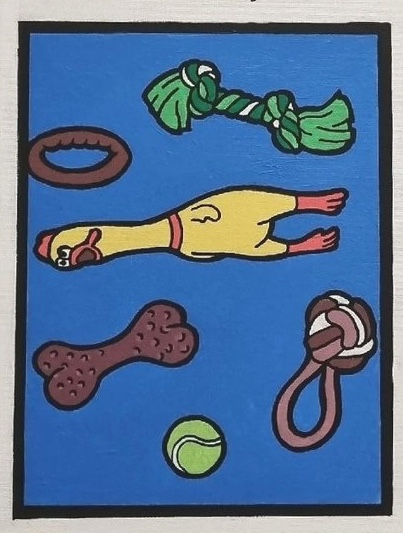

 58%|█████████████████████████████████████████████████████████████████▉                                               | 165/283 [00:07<00:05, 22.48it/s, current_usage=223, total_usage=176412]

{'id': 'chatcmpl-8i7O8JMLocbHrkr8oSywXtKtW0wtT', 'object': 'chat.completion', 'created': 1705525524, 'model': 'gpt-4-1106-vision-preview', 'usage': {'prompt_tokens': 95, 'completion_tokens': 128, 'total_tokens': 223}, 'choices': [{'message': {'role': 'assistant', 'content': "The image displays a collection of illustrated objects that are commonly associated with dogs, arranged against a blue background with a thin white border:\n\n1. At the top left is a brown chew toy that looks like a bone.\n2. Below that is a green tennis ball.\n3. Moving clockwise, there's a brown knotted rope toy.\n4. Next to it, at the top right, we see a dog treat or biscuit in a bone shape.\n5. At the center left, there's a yellow rubber chicken toy with red detailing, suggesting it's designed to be squeaky.\n6. Finally, at the top center, there"}, 'finish_reason': 'length', 'index': 0}]}


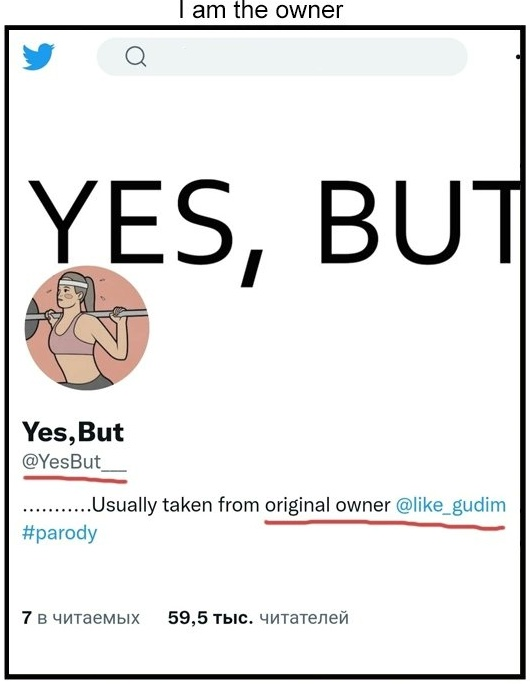

 79%|█████████████████████████████████████████████████████████████████████████████████████████                        | 223/283 [00:12<00:03, 17.42it/s, current_usage=446, total_usage=176635]

{'id': 'chatcmpl-8i7OFnUNwaaSifq9VnhswOomyohhL', 'object': 'chat.completion', 'created': 1705525531, 'model': 'gpt-4-1106-vision-preview', 'usage': {'prompt_tokens': 95, 'completion_tokens': 128, 'total_tokens': 223}, 'choices': [{'message': {'role': 'assistant', 'content': 'The image shows a screenshot of a social media post. At the top, a statement is partially visible that reads "I am the owner," which suggests that the user is asserting ownership or origin of the content below. \n\nThe main part of the screenshot is a tweet from a Twitter account by the name of "Yes, But" with the handle "@YesBut__". The tweet contains the text "..........Usually taken from original owner @like_gudim #parody". This suggests that the content is typically sourced from the mentioned account and is intended as a parody. \n\nThe account has a Twitter verification badge, indicating that it is'}, 'finish_reason': 'length', 'index': 0}]}


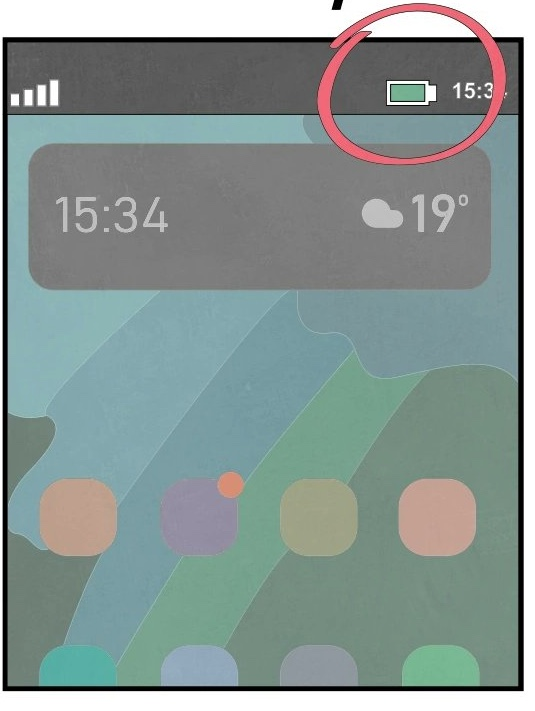

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:16<00:00, 16.82it/s, current_usage=669, total_usage=176858]

{'id': 'chatcmpl-8i7OKSoCfaZJhMiiuoiMFvGzXowgG', 'object': 'chat.completion', 'created': 1705525536, 'model': 'gpt-4-1106-vision-preview', 'usage': {'prompt_tokens': 95, 'completion_tokens': 128, 'total_tokens': 223}, 'choices': [{'message': {'role': 'assistant', 'content': "The image shows a portion of a smartphone screen, displaying the status bar at the top and a part of the home screen or a notification shade with a time widget and a weather widget. In the status bar, there's a battery icon that is highlighted with a red circle, indicating that it might be the element of interest. The time next to the battery is 15:34, and the battery indicator shows that it is almost fully charged.\n\nThe time widget on the larger portion of the screen also displays the same time, 15:34, while the weather widget indicates a temperature of 19 degrees Celsius, with a cloud symbol suggesting"}, 'finish_reason': 'length', 'index': 0}]}


In [19]:
import os, json
from tqdm import tqdm

## schema [{"image_path": <>, "prompt": <>, "usage": {"prompt_tokens": ...}}]
with open("gpt4-usages.json", "r") as f:
    usages = json.load(f)
    total_usage = sum(x["usage"]["total_tokens"] for x in usages)


outpath = "outputs/left/gpt4-vision-left.json"
try:
    with open(outpath, "r") as f:
        outputs = json.load(f)
except Exception:
    print("starting from zero")
    outputs = []

current_usage = 0
files = [x for x in os.listdir("images_split") if "YES" in x]
pbar = tqdm(files)
for filename in pbar:
    if filename in (o["image_path"] for o in outputs):
        continue
    prompt = "Describe this image"
    usage, output = generate(prompt, os.path.join("images_split", filename), True)

    outputs.append({"image_path":filename, "output": output})
    with open(outpath, "w") as f:
        json.dump(outputs, f, indent=2)

    usages.append({"image_path":filename, "prompt": prompt, "usage": usage})
    with open("gpt4-usages.json", "w") as f:
        json.dump(usages, f, indent=2)
    
    current_usage+=usage["total_tokens"]
    total_usage+=usage["total_tokens"]
    pbar.set_postfix({"current_usage": current_usage, "total_usage": total_usage})

    

In [ ]:
# whyfunny: 53930
# punchline: 63560
# left:
# right: 